<a href="https://colab.research.google.com/github/nicolas1805961/Deep-learning/blob/main/Projet_dlim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import zipfile
import shutil
import glob
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from math import ceil, floor

In [18]:
shutil.rmtree('/content/metadata', ignore_errors=True)

In [30]:
with zipfile.ZipFile('/content/drive/MyDrive/projet_dlim/wider_face_split.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/metadata/')
with zipfile.ZipFile('/content/drive/MyDrive/projet_dlim/WIDER_train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/train/')

In [56]:
train = {}
with open("/content/metadata/wider_face_split/wider_face_train_bbx_gt.txt") as file:
  lines = file.read().splitlines()
  file_name_line_number = 0
  face_line_number = 0
  while file_name_line_number < len(lines):
    number_of_faces = int(lines[file_name_line_number + 1])
    if number_of_faces is 0:
      number_of_faces += 1
    values = []
    key = lines[file_name_line_number]
    while face_line_number < number_of_faces:
      fields = lines[file_name_line_number + 2 + face_line_number].split()
      fields = list(map(int, fields))
      if fields[4] is not 0 or fields[5] is not 0 or fields[6] is not 0 or fields[7] is not 0 or fields[8] is not 0 or fields[9] is not 0:
        face_line_number += 1
        values = []
        break
      value = [x for x in fields[:4]]
      if value:
        values.append(value)
      face_line_number += 1
    if values:
      train[key] = values
    file_name_line_number += number_of_faces + 2
    face_line_number = 0

print(len(train))

3842


In [57]:
def get_aspect_ratio(train):
  aspect_ratio_list = []
  for subdir, dirs, files in os.walk('train'):
    for file in files:
      filepath = os.path.join(subdir, file)
      filepath_name = '/'.join(filepath.split('/')[3:])
      image_size = Image.open(filepath).size
      if image_size[0] < image_size[1] or filepath_name not in train:
        continue
      aspect_ratio_list.append(float(image_size[0]) / float(image_size[1]))
      
  print(np.median(aspect_ratio_list))
  print(np.array(aspect_ratio_list).mean())

get_aspect_ratio(train)

1.4545454545454546
1.450954067440557


In [100]:
image_list = []
label_list = []
filepath_list = []
for subdir, dirs, files in os.walk('train'):
  for file in files:
    filepath = os.path.join(subdir, file)
    filepath_name = '/'.join(filepath.split('/')[3:])
    image = Image.open(filepath)
    image_size = image.size
    if image_size[0] < image_size[1] or filepath_name not in train:
      continue

    image = np.array(image)
    ratio = min(256 / image.shape[1], 176 / image.shape[0])
    new_shape = (round(image.shape[1] * ratio), round(image.shape[0] * ratio))
    image = cv.resize(image, new_shape, interpolation=cv.INTER_CUBIC)

    label = np.zeros(image.shape[:-1], dtype=np.uint8)

    for bb in train[filepath_name]:
      label[round(bb[1] * ratio):round((bb[1] + bb[3]) * ratio), round(bb[0] * ratio):round((bb[0] + bb[2]) * ratio)] = 1

    padding_amount_rows = (176 - image.shape[0]) / 2
    padding_amount_cols = (256 - image.shape[1]) / 2


    image = np.pad(image, ((floor(padding_amount_rows), ceil(padding_amount_rows)), (floor(padding_amount_cols), ceil(padding_amount_cols)), (0, 0)))
    label = np.pad(label, ((floor(padding_amount_rows), ceil(padding_amount_rows)), (floor(padding_amount_cols), ceil(padding_amount_cols))))
    image_list.append(image)
    label_list.append(label)
    filepath_list.append(filepath_name)
    
images = np.stack(image_list)
labels = np.stack(label_list)
print(images.shape)
print(labels.shape)

(2190, 176, 256, 3)
(2190, 176, 256)


49--Greeting/49_Greeting_peoplegreeting_49_74.jpg
[0 1]
32--Worker_Laborer/32_Worker_Laborer_Worker_Laborer_32_273.jpg
[0 1]
13--Interview/13_Interview_Interview_Sequences_13_487.jpg
[0 1]
20--Family_Group/20_Family_Group_Family_Group_20_562.jpg
[0 1]
7--Cheering/7_Cheering_Cheering_7_817.jpg
[0 1]


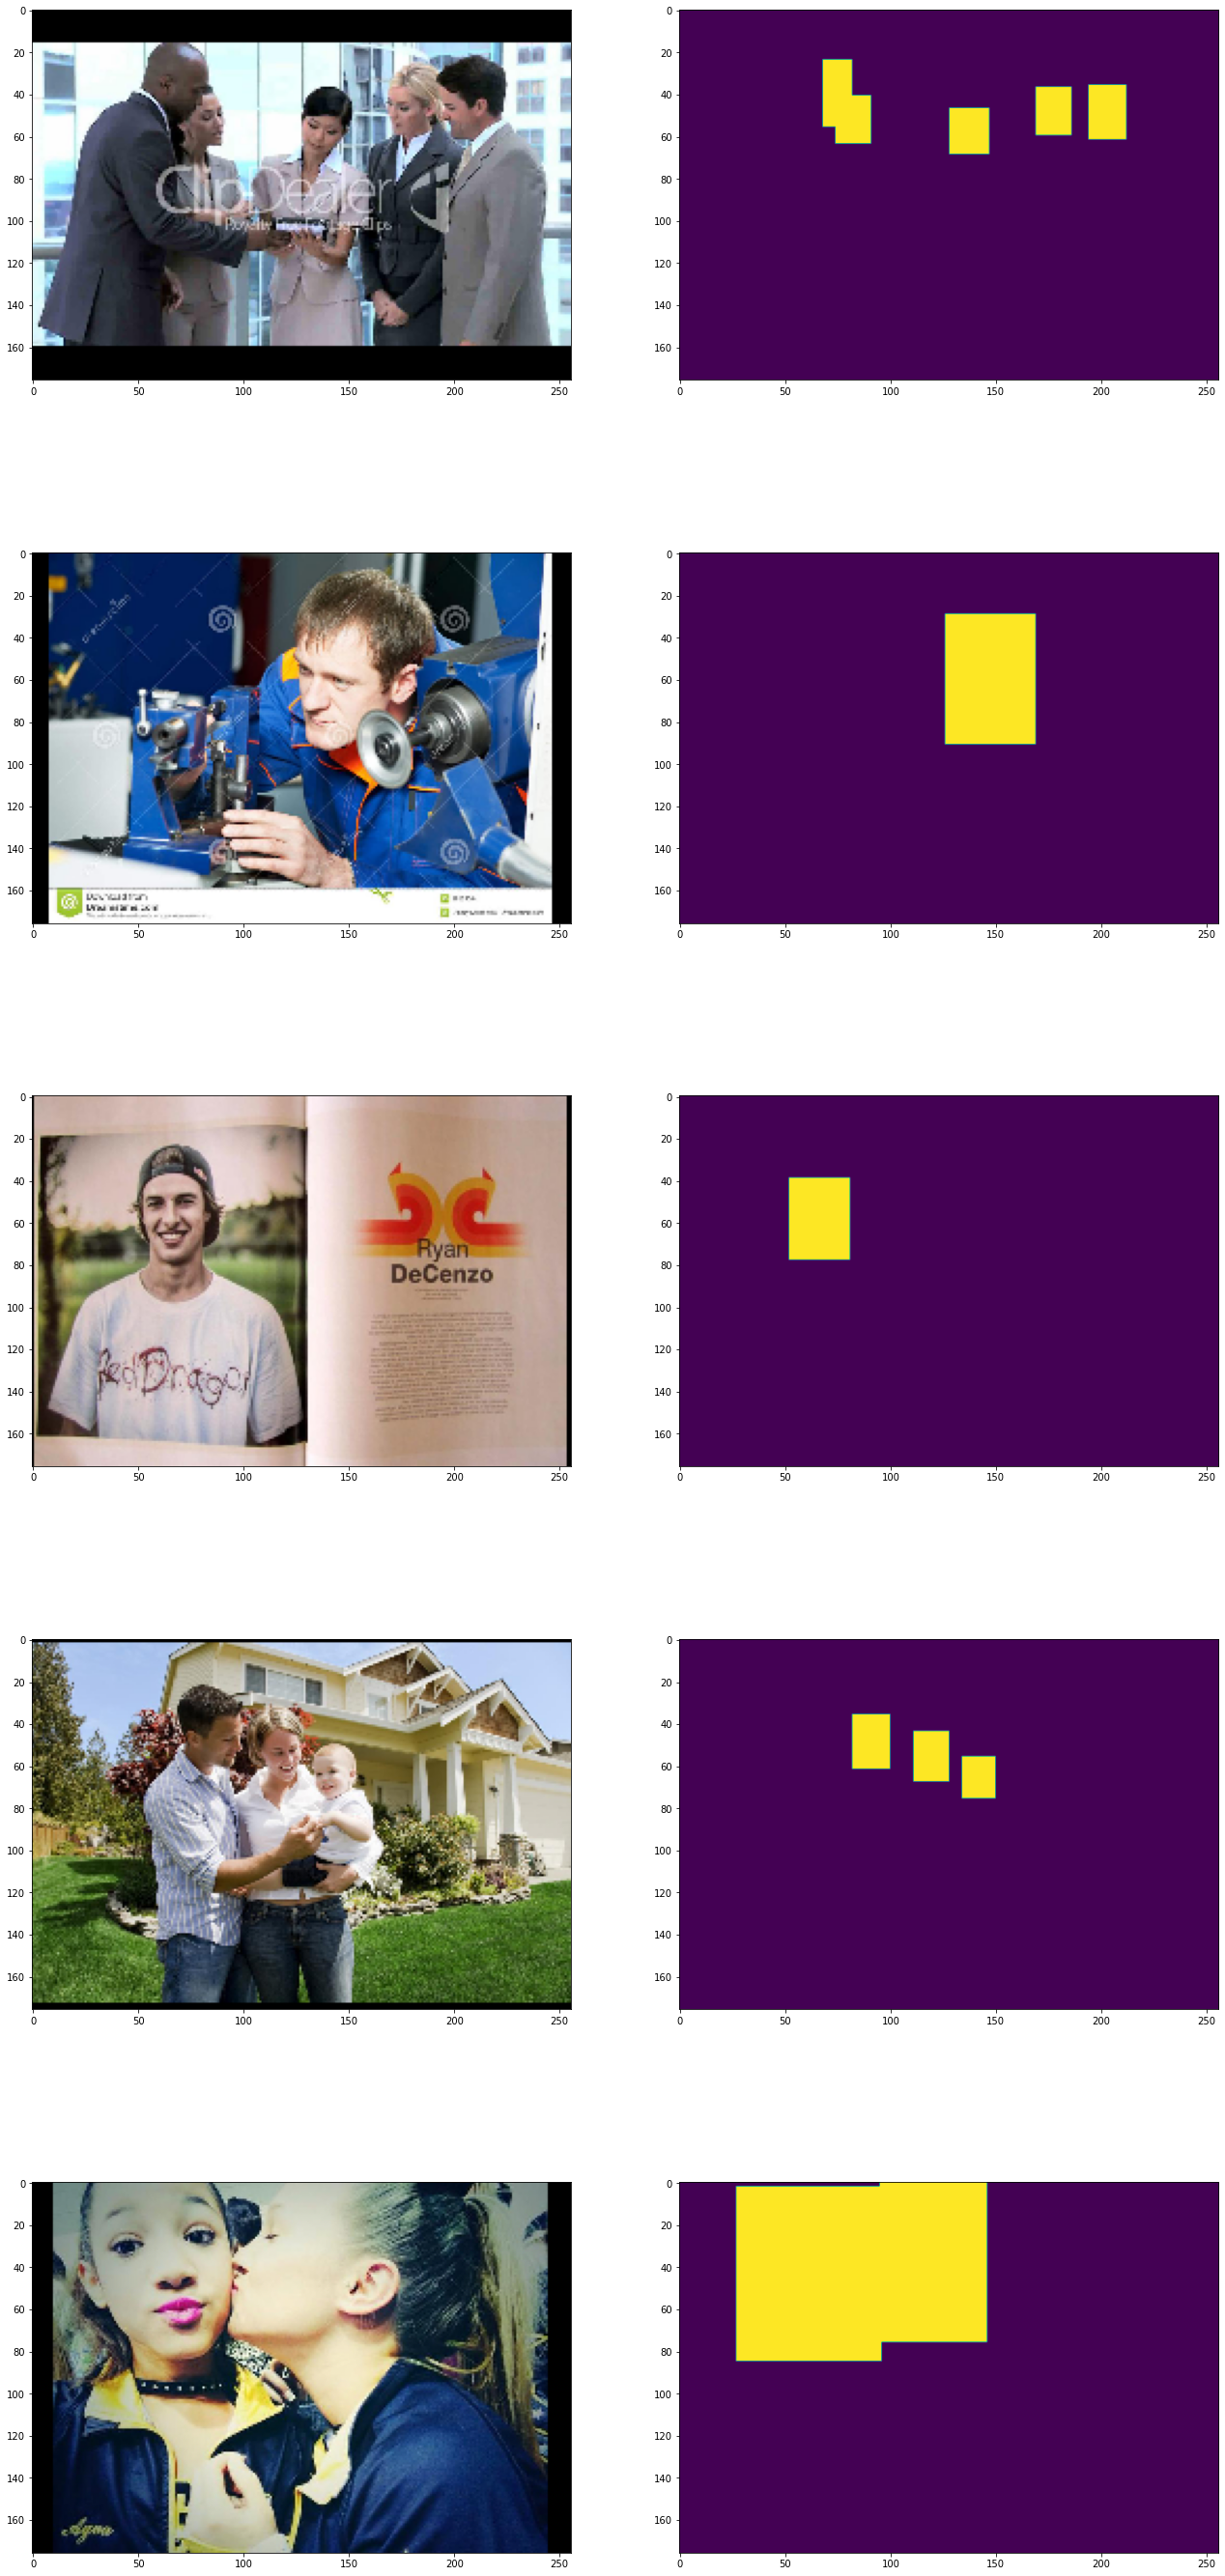

In [101]:
fig, ax = plt.subplots(5, 2, figsize=(22, 50))
indices = np.random.randint(0, images.shape[0], 5)
for plot_index, image_index in zip(range(5), indices):
  print(filepath_list[image_index])
  print(np.unique(labels[image_index]))
  ax[plot_index, 0].imshow(images[image_index])
  ax[plot_index, 1].imshow(labels[image_index])